In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd

%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [14]:
# Setup the figures
execfile('../code/figure-setup.py')

##Get all of the data for the BAT AGN

In [35]:
# Upload the fitting results for the C12 model
bat_casey = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/'+
                        'analysis/casey_bayes_results/beta_fixed_2_wturn_gaussianPrior/'+
                        'final_fit_results_beta_fixed_2_wturn_gaussianPrior_v3.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/'+
                                   'final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected.csv', index_col=0)
# Remove 'bad' sources
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))
bat_casey_undetected['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                                np.log10(bat_koss['SDSS_Li']/3.846e33))

##Get all of the data for the HRS sample

In [7]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

hrs_casey['Mstar'] = hrs_info['logMstart']

##Get all of the data for the KINGFISH galaxies

In [39]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv',
                       index_col=0)

# Upload the KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt',
                        index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
kf_dwarfs = kf_info['Mstar'] < 8.0

kf_casey['Mstar'] = kf_info['Mstar']

In [40]:
# Calculate SFR for all three samples
bat_casey['SFR'] = bat_casey['lir_bb'] + np.log10(4./3.) + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey['SFR'] = hrs_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
kf_casey['SFR'] = kf_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43) 

## Dust Mass, Dust Temperature, and SFR Comparison

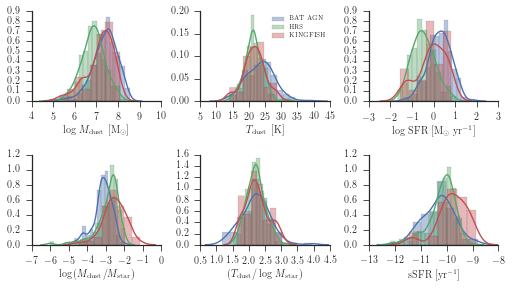

In [50]:
fig = plt.figure(figsize=(1.2*textwidth, 1./2.*1.2*textwidth))
ax1 = fig.add_subplot(231)
sn.distplot(bat_casey['mdust'].dropna(), label='BAT AGN', color='b', ax=ax1)
sn.distplot(hrs_casey['mdust'].dropna(), label='HRS', color='g', ax=ax1)
sn.distplot(kf_casey['mdust'][~kf_dwarfs].dropna(), label='KINGFISH', color='r', ax=ax1)
plt.xlabel(r'$\log\,M_{\rm dust}$ [M$_{\odot}$]')
sn.despine()

ax2 = fig.add_subplot(232)
sn.distplot(bat_casey['tdust'].dropna(), label='BAT AGN', color='b', ax=ax2)
sn.distplot(hrs_casey['tdust'].dropna(), label='HRS', color='g', ax=ax2)
sn.distplot(kf_casey['tdust'][~kf_dwarfs].dropna(), label='KINGFISH', color='r', ax=ax2)
plt.xlabel(r'$T_{\rm dust}$ [K]')
plt.legend(loc='upper right', fontsize=6)
sn.despine()

ax3 = fig.add_subplot(233)
sn.distplot(bat_casey['SFR'].dropna(), label='BAT AGN', color='b', ax=ax3)
sn.distplot(hrs_casey['SFR'].dropna(), label='HRS', color='g', ax=ax3)
sn.distplot(kf_casey['SFR'][~kf_dwarfs].dropna(), label='KINGFISH', color='r', ax=ax3)
plt.xlabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
sn.despine()

ax4 = fig.add_subplot(234)
sn.distplot((bat_casey['mdust'] - bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax4)
sn.distplot((hrs_casey['mdust'] - hrs_casey['Mstar']).dropna(), label='HRS', color='g', ax=ax4)
sn.distplot((kf_casey['mdust'][~kf_dwarfs] - kf_casey['Mstar'][~kf_dwarfs]).dropna(), label='KINGFISH', color='r', ax=ax4)
plt.xlabel(r'$\log\,(M_{\rm dust}/M_{\rm star})$')
sn.despine()


ax5 = fig.add_subplot(235)
sn.distplot((bat_casey['tdust']/bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax5)
sn.distplot((hrs_casey['tdust']/hrs_casey['Mstar']).dropna(), label='HRS', color='g', ax=ax5)
sn.distplot((kf_casey['tdust'][~kf_dwarfs]/kf_casey['Mstar'][~kf_dwarfs]).dropna(), label='KINGFISH', color='r', ax=ax5)
plt.xlabel(r'$(T_{\rm dust}/\log\,M_{\rm star})$')
sn.despine()

ax6 = fig.add_subplot(236)
sn.distplot((bat_casey['SFR'] - bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax6)
sn.distplot((hrs_casey['SFR'] - hrs_casey['Mstar']).dropna(), label='HRS', color='g', ax=ax6)
sn.distplot((kf_casey['SFR'][~kf_dwarfs] - kf_casey['Mstar'][~kf_dwarfs]).dropna(), label='KINGFISH', color='r', ax=ax6)
plt.xlabel(r'sSFR [yr$^{-1}$]')
sn.despine()

fig.subplots_adjust(wspace=0.3, hspace=0.6)

fig.savefig('../figures/mdust_tdust_sfr_comparison.pdf', bbox_inches='tight')

In [34]:
bat_casey.columns

Index([u'agn_frac', u'agn_frac_16', u'agn_frac_2_5', u'agn_frac_84',
       u'agn_frac_95', u'agn_frac_97_5', u'alpha', u'alpha_16', u'alpha_84',
       u'lir_bb', u'lir_bb_16', u'lir_bb_2_5', u'lir_bb_84', u'lir_bb_97_5',
       u'lir_powlaw', u'lir_powlaw_16', u'lir_powlaw_2_5', u'lir_powlaw_84',
       u'lir_powlaw_97_5', u'lir_total', u'lir_total_16', u'lir_total_2_5',
       u'lir_total_84', u'lir_total_97_5', u'mdust', u'mdust_16', u'mdust_84',
       u'norm_pow', u'norm_pow_16', u'norm_pow_84', u'tdust', u'tdust_16',
       u'tdust_84', u'wturn', u'wturn_16', u'wturn_84', u'SFR'],
      dtype='object')